## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

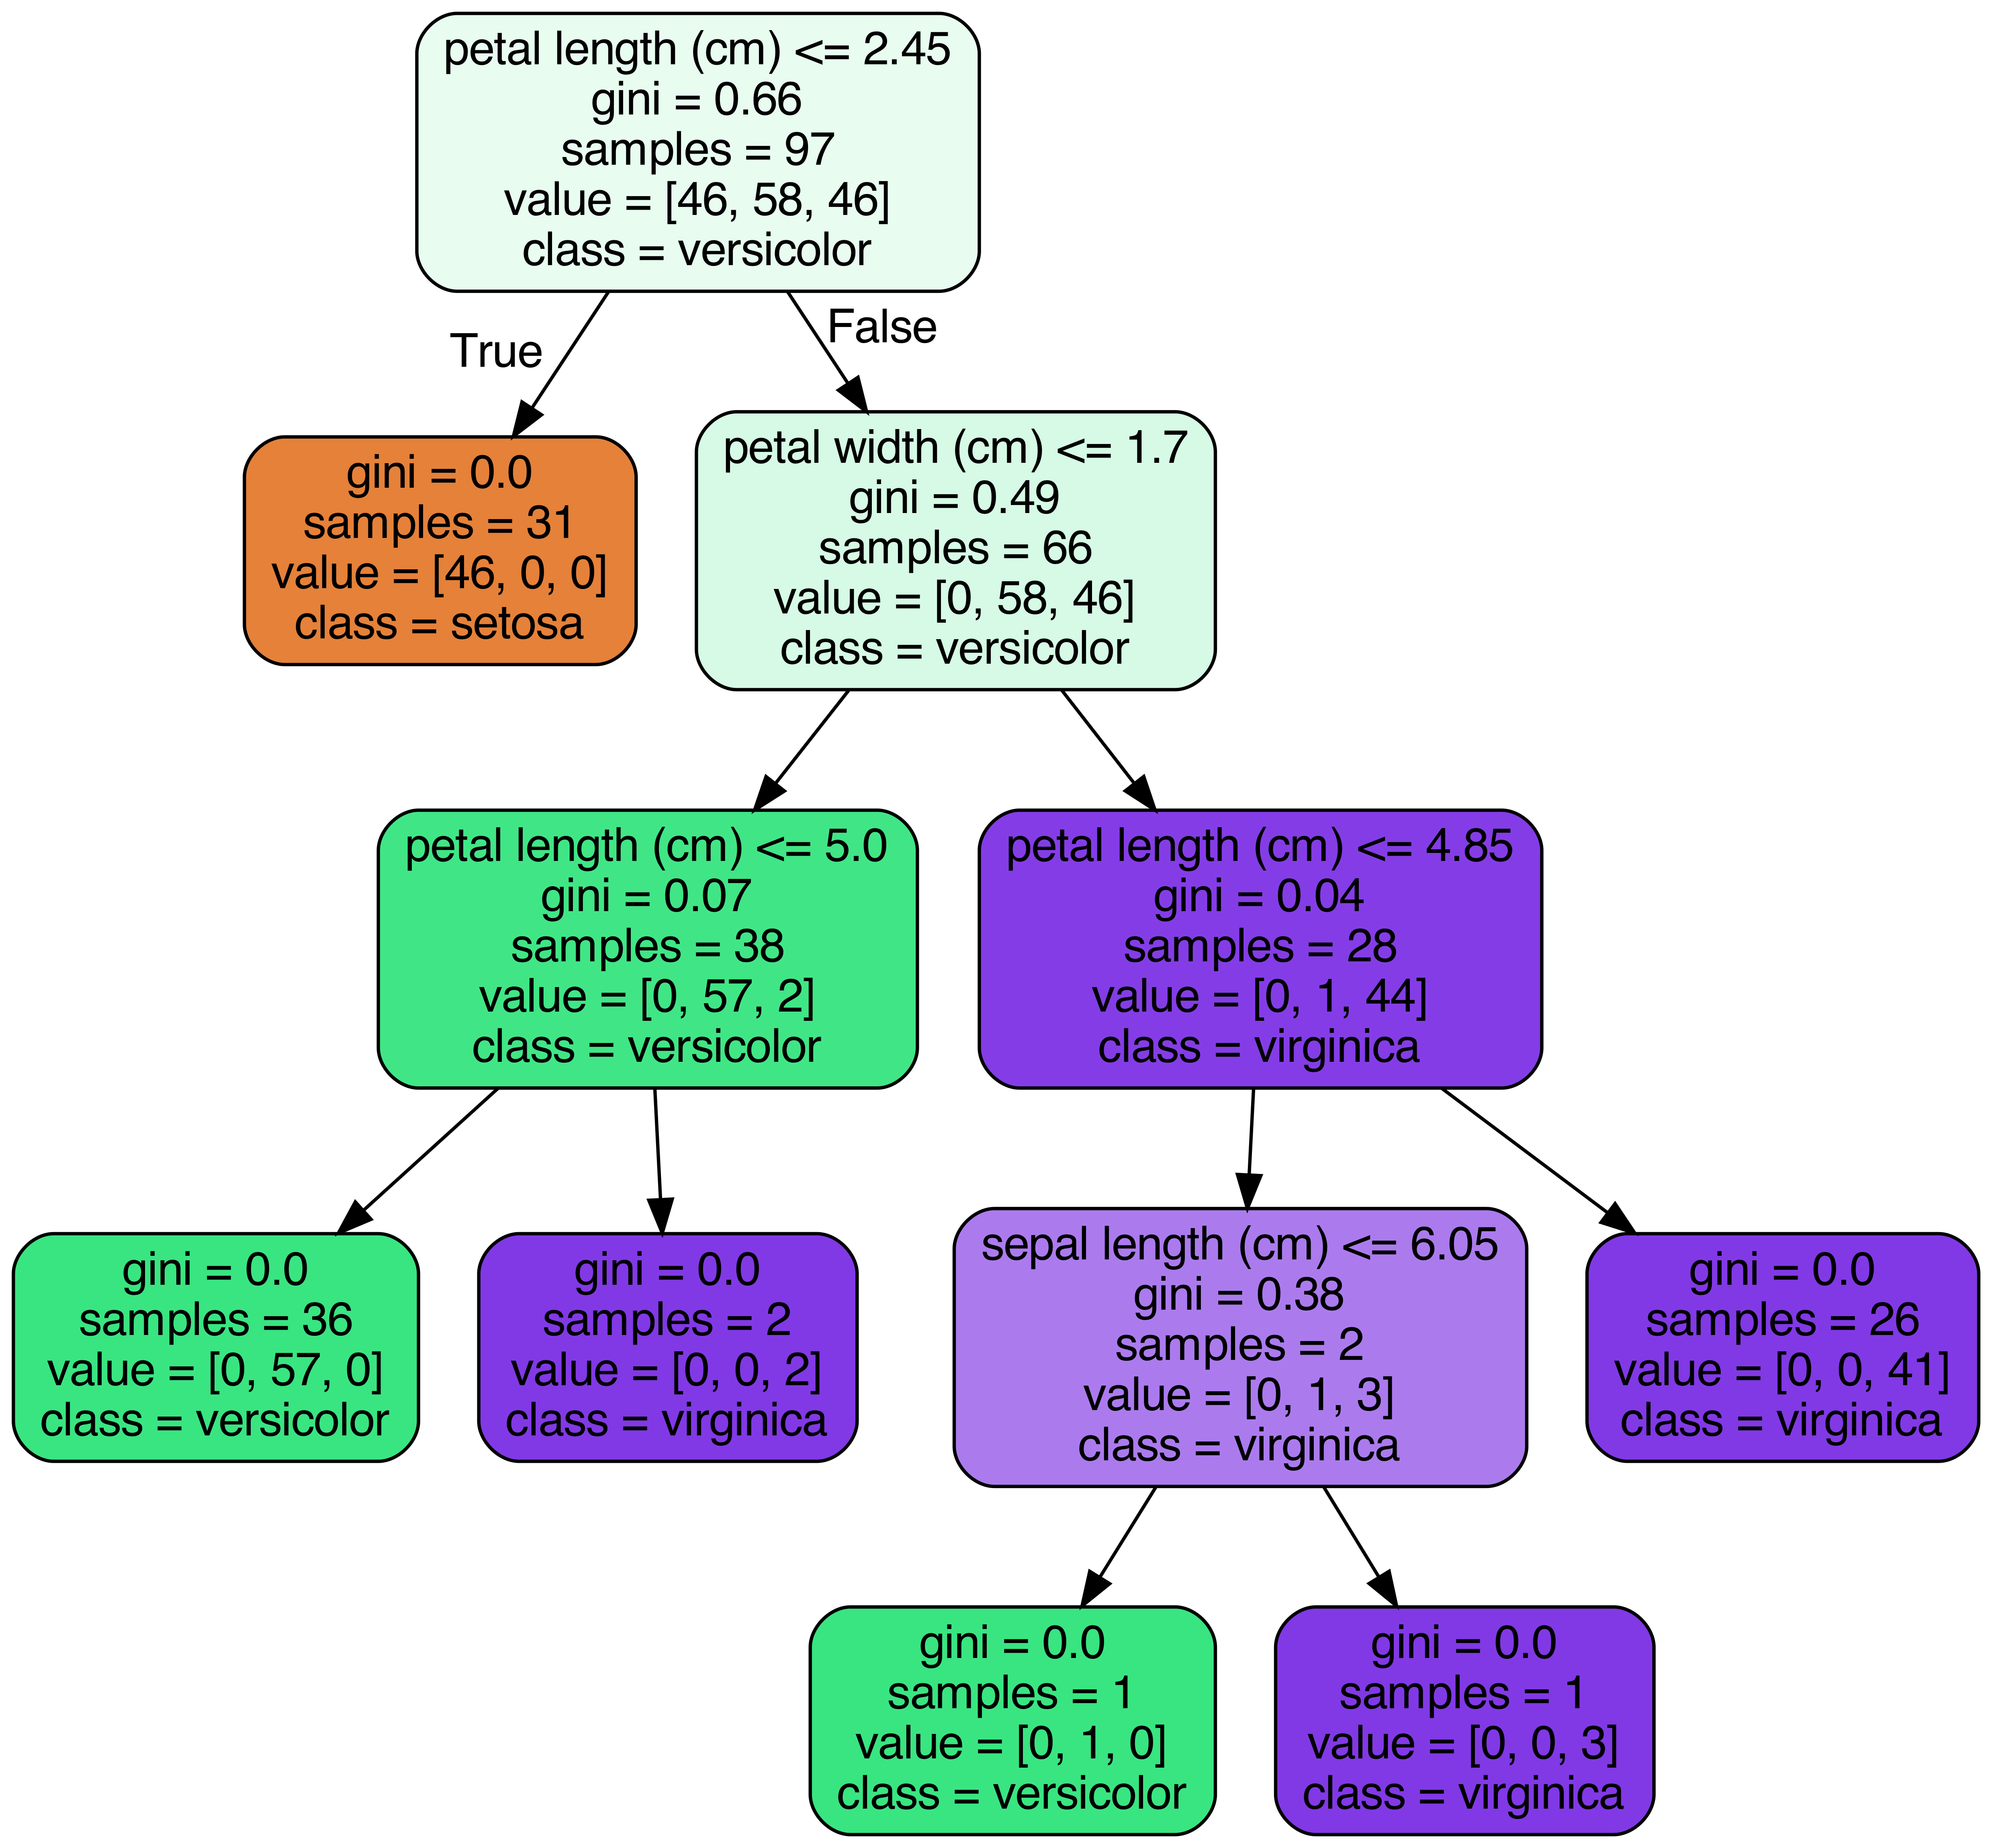

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

In [8]:
#curr_year = datetime.now().year
curr_year = 2020      # We choose the current year to be 2020 since the data was created at the moment.
print('current year is {}'.format(curr_year))

df['n_age'] = curr_year - df.birth_year

current year is 2020


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.isnull().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
df.disease.fillna(0, inplace=True)         # fill the missing values with 0
df.loc[df.disease==True, 'disease'] = 1    # remap the True values to 1

print(df.disease.unique())

[0 1]


 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [12]:
df.global_num.fillna(df.global_num.mean(), inplace=True)
df.birth_year.fillna(round(df.birth_year.mean(),0), inplace=True)  # round the birth_year value to remove the decimal points 
df.infection_order.fillna(df.infection_order.mean(), inplace=True)
df.infected_by.fillna(df.infected_by.mean(), inplace=True)
df.contact_number.fillna(df.contact_number.mean(), inplace=True)

In [13]:
df.sample(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
1224,6001000150,3568.000000,female,1932.0,80s,Korea,Gyeongsangbuk-do,Gyeongsan-si,0,NaN,2.285714,2.600789e+09,24.128954,NaN,2020-03-01,NaN,NaN,isolated,88.0
65,1000000066,2470.000000,male,1986.0,30s,Korea,Seoul,Gangnam-gu,0,etc,2.285714,2.600789e+09,24.128954,NaN,2020-02-29,2020-03-04,NaN,released,34.0
1013,4100000068,4664.816591,male,1972.0,40s,Korea,Chungcheongnam-do,Cheonan-si,0,contact with patient,2.285714,4.100000e+09,3.000000,NaN,2020-03-01,NaN,NaN,isolated,48.0
1769,6008000044,4664.816591,NaN,1975.0,NaN,Korea,Gyeongsangbuk-do,Bonghwa-gun,0,NaN,2.285714,2.600789e+09,24.128954,NaN,NaN,NaN,NaN,isolated,NaN
1991,6020000004,4664.816591,male,1975.0,40s,Korea,Gyeongsangbuk-do,Cheongdo-gun,0,Cheongdo Daenam Hospital,2.285714,2.600789e+09,24.128954,NaN,2020-02-20,NaN,NaN,isolated,NaN


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [14]:
''' check the null '''
df.isnull().sum().sort_values(ascending=False)

deceased_date         2186
symptom_onset_date    2025
released_date         1995
infection_case        1055
n_age                  454
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
country                  0
province                 0
disease                  0
global_num               0
infection_order          0
infected_by              0
contact_number           0
birth_year               0
patient_id               0
dtype: int64

In [15]:
""" format to datetime """

df.deceased_date = pd.to_datetime(df.deceased_date)   #.dt.date
df.symptom_onset_date = pd.to_datetime(df.symptom_onset_date) #.dt.date
df.released_date = pd.to_datetime(df.released_date) #.dt.date
df.confirmed_date = pd.to_datetime(df.confirmed_date) #.dt.date

In [16]:
''' missing values for confirmed_date
    it would be cautious but may be arguably okay to set the Null confirmed_date to random date between min and max confirmed_date
'''

# first, check if the randomness of the missing confirmed_date affects to other dates.
print(len(df.loc[df.symptom_onset_date.isnull() & df.confirmed_date.isnull() & df.released_date.isnull()]))

141


> **Note:** We could see that all rows that have missing data in `confirmed_date` also have missing data in `symptom_onset_date` and `released_date`. So, it should be fine to choose the missing value of the confirmed_date randomly within the min & max range of given confirmed_date.

In [17]:
n_null_confirmed_date = len(df.loc[df.confirmed_date.isnull()])   # total number of missing values for confirmed_date
print("number of missing value in confirmed_date: {:d}".format(n_null_confirmed_date))

# range between two days
start_date = df.confirmed_date.min()    
end_date = df.confirmed_date.max()

days_diff = (end_date - start_date).days    # differences in day unit
print("earliest date: {}, latest date: {}, difference between two dates: {} days".format(start_date.date(), end_date.date(), days_diff))

# initiate the random date
random_date = np.empty(n_null_confirmed_date, dtype='datetime64[ns]')

for i in range(n_null_confirmed_date):
    rand_days = random.randrange(days_diff)    # random number generation (0 - days_diff)
    random_date[i] = start_date + timedelta(days=rand_days)

#print(random_date)

# assign the random value to the missing data
df.loc[df.confirmed_date.isnull(), 'confirmed_date'] = random_date

number of missing value in confirmed_date: 141
earliest date: 2020-01-20, latest date: 2020-03-18, difference between two dates: 58 days


In [18]:
''' 
    Given the limited information, it might not be bad if we fill the missing of symptom_onset_date and released_date using 
    the mean value of the difference from the confirmed_date.
'''

# create subset to draw the mean difference between symptom_onset_date and confirmed_date
df2 = df.loc[(df.symptom_onset_date.isnull()==False) & (df.confirmed_date.isnull()==False)].copy()
df2['onset_confirm'] = df2.confirmed_date - df2.symptom_onset_date
onset_confirm_avg = df2.onset_confirm.mean()
print("average date from symptom_onset_date to confirmed_date: {}".format(onset_confirm_avg))
#df2.head()

# create subset to draw the mean difference between confirmed_date and released_date
df3 = df.loc[(df.confirmed_date.isnull()==False) & (df.released_date.isnull()==False)].copy()
df3['confirm_release'] = df3.released_date - df3.confirmed_date
confirm_release_avg = df3.confirm_release.mean()
print("average date from confirmed_date to released_date: {}".format(confirm_release_avg))

print("length of subsets: {} and {}".format(len(df2), len(df3)))

average date from symptom_onset_date to confirmed_date: 4 days 06:57:49.430051813
average date from confirmed_date to released_date: 13 days 19:54:37.130044843
length of subsets: 193 and 223


In [19]:
# assign the missing values by adding (or subtracting) the average values from confirmed_date
df.loc[df.symptom_onset_date.isnull(),'symptom_onset_date'] = df.loc[df.symptom_onset_date.isnull(),'confirmed_date'] - onset_confirm_avg
df.loc[df.released_date.isnull(),'released_date']           = df.loc[df.released_date.isnull(),'confirmed_date'] + confirm_release_avg

In [20]:
''' missing values for deceased_date.
    1) check if there is anyone whose state is deceased but there is no deceased_date.
    --> it can be approximated to confirmed date
    2) otherwise, it would be reasonable to replace it to dummy value like 9999-99-99, since the patients are still alive.
    Note that it will change the type of deceased_date column from datetime to object.
'''

# check deceased state but missing deceased_date
is_deceased_nodate = (df.state=='deceased') & (df.deceased_date.isnull())
df.loc[is_deceased_nodate]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
1611,6002000002,4664.816591,male,1980.0,40s,Korea,Gyeongsangbuk-do,Gyeongju-si,0,NaN,2.285714,2.600789e+09,24.128954,2020-02-17 17:02:10.569948187,2020-02-22,2020-03-06 19:54:37.130044843,NaT,deceased,40.0
1946,6016000035,4664.816591,NaN,1975.0,NaN,Korea,Gyeongsangbuk-do,Yecheon-gun,0,NaN,2.285714,2.600789e+09,24.128954,2020-02-18 17:02:10.569948187,2020-02-23,2020-03-07 19:54:37.130044843,NaT,deceased,NaN


> **Note:** Here `released_date` was approximated previously, but this cannot be real since the patients were already died. We will replace the `released_date` to the `confirmed_date`

In [21]:
# replace the released_date to confirmed_date and fill the missing deceased_date with confirmed_date
df.loc[is_deceased_nodate, 'released_date'] = df.loc[is_deceased_nodate, 'confirmed_date']
df.loc[is_deceased_nodate, 'deceased_date'] = df.loc[is_deceased_nodate, 'confirmed_date']

# Otherwise, the missing deceased_date case should be simply those who are still alive. -> assign the dummy value like 9999-99-99
df.loc[df.deceased_date.isnull(),'deceased_date'] = '9999-99-99'   # pd.Timestamp.max

In [22]:
''' fill the missing value of the infection_case '''
df.infection_case.value_counts()

contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

> It seems that there is 'etc', to which our missing values can be assigned. 

In [23]:
df.loc[df.infection_case.isnull(), 'infection_case'] = 'etc'

In [24]:
''' re-calculate the n_age using updated birth_year.'''
df.loc[df.n_age.isnull(),'n_age'] = curr_year - df.loc[df.n_age.isnull(),'birth_year']   # here curr_year is current year that is 2020. 

In [25]:
''' fill the missing age (string value with 's') '''

# extract a subset
df4 = df[df.age.isnull()].copy()
df4.age = (df4.n_age//10*10).astype(int).astype(str) + 's'

df4[['age','n_age']]

,age,n_age
779,30s,34.0
780,60s,61.0
781,20s,29.0
782,60s,67.0
783,0s,2.0
...,...,...
1946,40s,45.0
1947,40s,45.0
2159,40s,45.0
2160,40s,45.0


In [26]:
# merge the corrected age back to original dataframe

df.loc[df.age.isnull(),'age'] = df4.age

In [27]:
''' fill the missing sex values as unknown '''

print('*'*5+' before correction '+'*'*5)
print(df.sex.unique())
df.loc[df.sex.isnull(), 'sex'] = 'unknown'
print('*'*5+' after correction '+'*'*5)
print(df.sex.unique())

***** before correction *****
['male' 'female' nan]
***** after correction *****
['male' 'female' 'unknown']


In [28]:
''' fill the missing state values as missing '''

print('*'*5+' before correction '+'*'*5)
print(df.state.unique())
df.loc[df.state.isnull(), 'state'] = 'missing'
print('*'*5+' after correction '+'*'*5)
print(df.state.unique())

***** before correction *****
['released' 'isolated' 'deceased' nan]
***** after correction *****
['released' 'isolated' 'deceased' 'missing']


In [29]:
''' fill the missing city value as the location that has largest number of patients for each province. 
    Note that city should be located within each province.
'''

print("City name that has most patients for each province")
print("="*50)
for iprov in df.province.unique():
    list_most_city = df.loc[df.province==iprov,'city'].value_counts(ascending=False)
    if (len(list_most_city) == 0):       # if all city names are null in the province, it is set to the province name
        most_n_city_in_prov = iprov
    else:
        most_n_city_in_prov = list_most_city.index[0]
    print('{} in {}'.format(most_n_city_in_prov, iprov))
    
    # fill the missing city to the one with largest number of patients
    df.loc[df.city.isnull() & (df.province==iprov),'city'] = most_n_city_in_prov

City name that has most patients for each province
Dongdaemun-gu in Seoul
Dongnae-gu in Busan
Nam-gu in Daegu
Gwangju in Gwangju
Bupyeong-gu in Incheon
Yuseong-gu in Daejeon
Nam-gu in Ulsan
Sejong in Sejong
Seongnam-si in Gyeonggi-do
Wonju-si in Gangwon-do
Goesan-gun in Chungcheongbuk-do
Cheonan-si in Chungcheongnam-do
etc in Jeollabuk-do
Suncheon-si in Jeollanam-do
Gyeongsan-si in Gyeongsangbuk-do
Changwon-si in Gyeongsangnam-do
Jeju-do in Jeju-do


 **<font color='teal'> Check for any remaining null values.</font>**

In [30]:
''' Check the null values '''
df.isnull().sum().sort_values(ascending=False)

patient_id            0
infection_order       0
state                 0
deceased_date         0
released_date         0
confirmed_date        0
symptom_onset_date    0
contact_number        0
infected_by           0
infection_case        0
global_num            0
disease               0
city                  0
province              0
country               0
age                   0
birth_year            0
sex                   0
n_age                 0
dtype: int64

In [31]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22 00:00:00.000000000,2020-01-23,2020-02-05,9999-99-99,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-01-25 17:02:10.569948187,2020-01-30,2020-03-02,9999-99-99,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-01-25 17:02:10.569948187,2020-01-30,2020-02-19,9999-99-99,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26 00:00:00.000000000,2020-01-30,2020-02-15,9999-99-99,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-01-26 17:02:10.569948187,2020-01-31,2020-02-24,9999-99-99,released,28.0


Remove date columns from the data.


In [32]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [33]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   3
birth_year           96
age                  11
country               4
province             17
city                135
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                96
dtype: int64


Review the percent of unique values by column.

In [34]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.001353
birth_year         0.043282
age                0.004959
country            0.001803
province           0.007665
city               0.060866
disease            0.000902
infection_case     0.007214
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043282
dtype: float64


Review the range of values per column.

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2218.0,4.664817e+03,2.211785e+03,1.000000e+00,4.205250e+03,4.664817e+03,5.900250e+03,8.717000e+03
birth_year,2218.0,1.974991e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.975000e+03,1.988000e+03,2.020000e+03
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.500902e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.500000e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [36]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [37]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,3
1,age,11
2,country,4
3,province,17
4,city,135
5,disease,2
6,infection_case,16
7,state,4


**<font color='teal'> Plot the correlation heat map for the features.</font>**

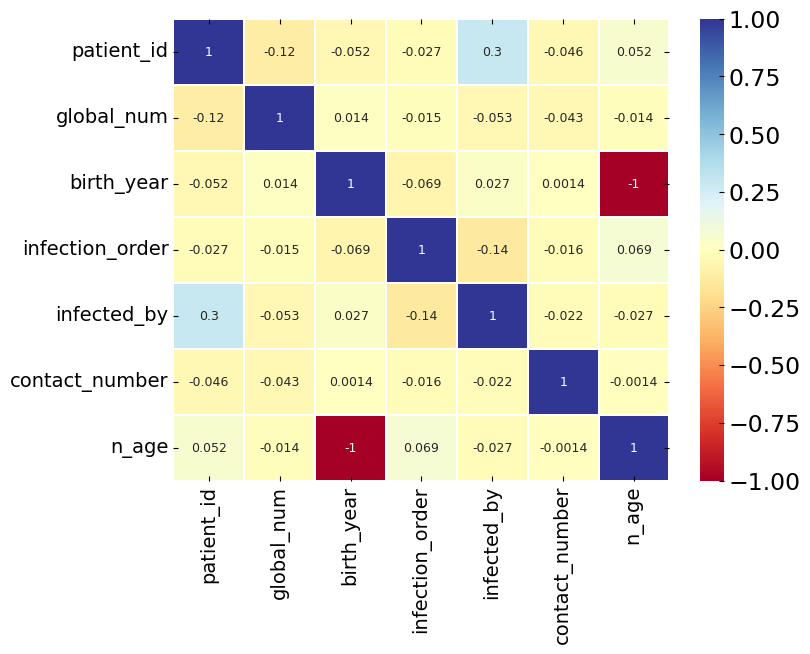

In [38]:
fig, ax = plt.subplots()
# Make a heatmap of the data 
sns.heatmap(df.corr(), linewidth=.1, annot=True, annot_kws={"size":9}, cmap="RdYlBu", ax=ax)

ax.tick_params(axis='both', labelsize=14);

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

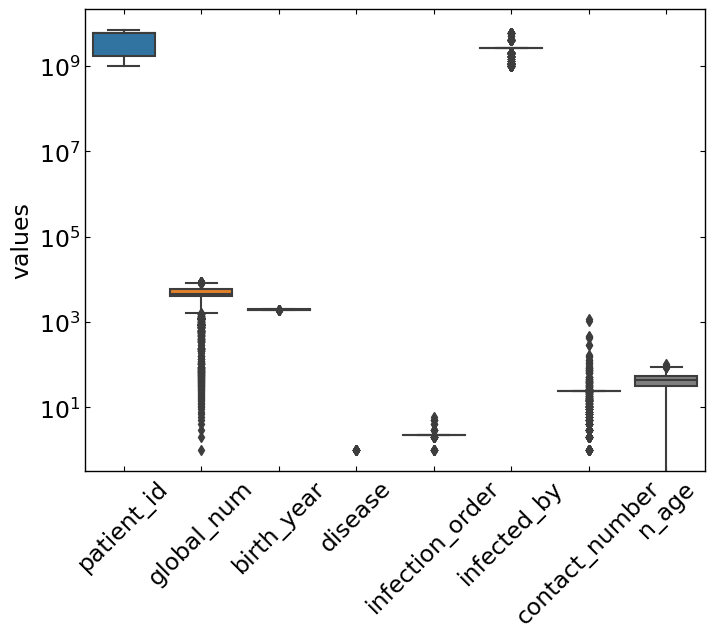

In [39]:
ax=sns.boxplot(data=df)
ax.set_yscale('log')
ax.set_ylabel('values')
ax.tick_params(axis='x', rotation=45)

**<font color='teal'> Create dummy features for object type features. </font>**

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       2218 non-null   float64
 2   sex              2218 non-null   object 
 3   birth_year       2218 non-null   float64
 4   age              2218 non-null   object 
 5   country          2218 non-null   object 
 6   province         2218 non-null   object 
 7   city             2218 non-null   object 
 8   disease          2218 non-null   object 
 9   infection_case   2218 non-null   object 
 10  infection_order  2218 non-null   float64
 11  infected_by      2218 non-null   float64
 12  contact_number   2218 non-null   float64
 13  state            2218 non-null   object 
 14  n_age            2218 non-null   float64
dtypes: float64(6), int64(1), object(8)
memory usage: 260.0+ KB


In [41]:
#dfo = df.drop(columns=['state']).select_dtypes(include=['object'], exclude=['datetime'])
df_dummy = pd.get_dummies(df.drop(columns=['state']), drop_first=True)

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [42]:
df_dummy.columns

Index(['patient_id', 'global_num', 'birth_year', 'infection_order',
       'infected_by', 'contact_number', 'n_age', 'sex_male', 'sex_unknown',
       'age_100s',
       ...
       'infection_case_Pilgrimage to Israel',
       'infection_case_River of Grace Community Church',
       'infection_case_Seongdong-gu APT', 'infection_case_Shincheonji Church',
       'infection_case_Suyeong-gu Kindergarten',
       'infection_case_contact with patient', 'infection_case_etc',
       'infection_case_gym facility in Cheonan',
       'infection_case_gym facility in Sejong',
       'infection_case_overseas inflow'],
      dtype='object', length=188)

In [43]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Columns: 188 entries, patient_id to infection_case_overseas inflow
dtypes: float64(6), int64(1), uint8(181)
memory usage: 513.5 KB


### Split the data into test and train subsamples

In [44]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
X = df_dummy
y = df.state

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [45]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [46]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [47]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.851
Random Forest: f1-score=0.817


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [48]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   1   0   0]
 [  0 344   0   7]
 [  0   2  15   0]
 [  0  56   0  13]]
Normalized confusion matrix
[[0.86 0.14 0.   0.  ]
 [0.   0.98 0.   0.02]
 [0.   0.12 0.88 0.  ]
 [0.   0.81 0.   0.19]]


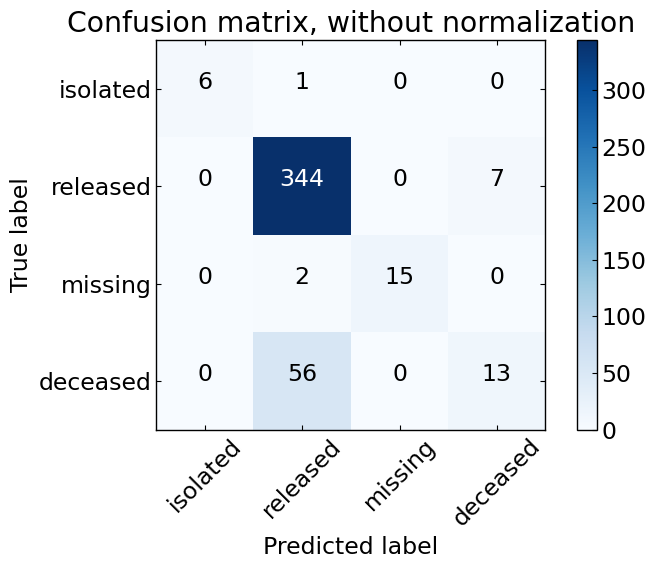

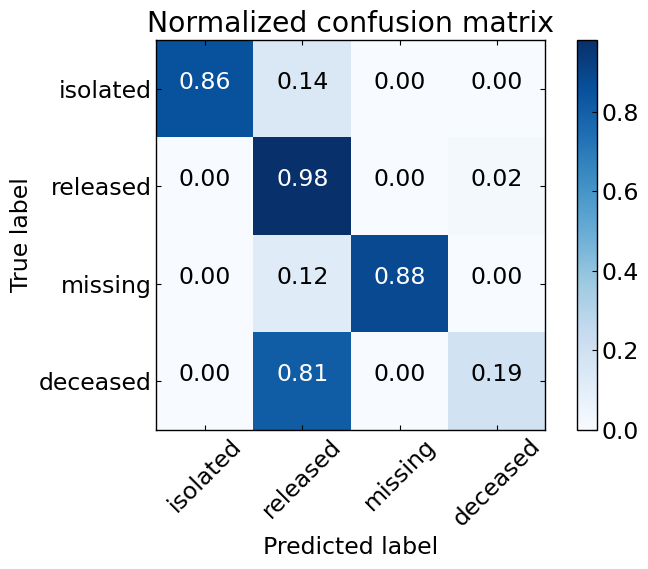

In [49]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix');
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
#plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


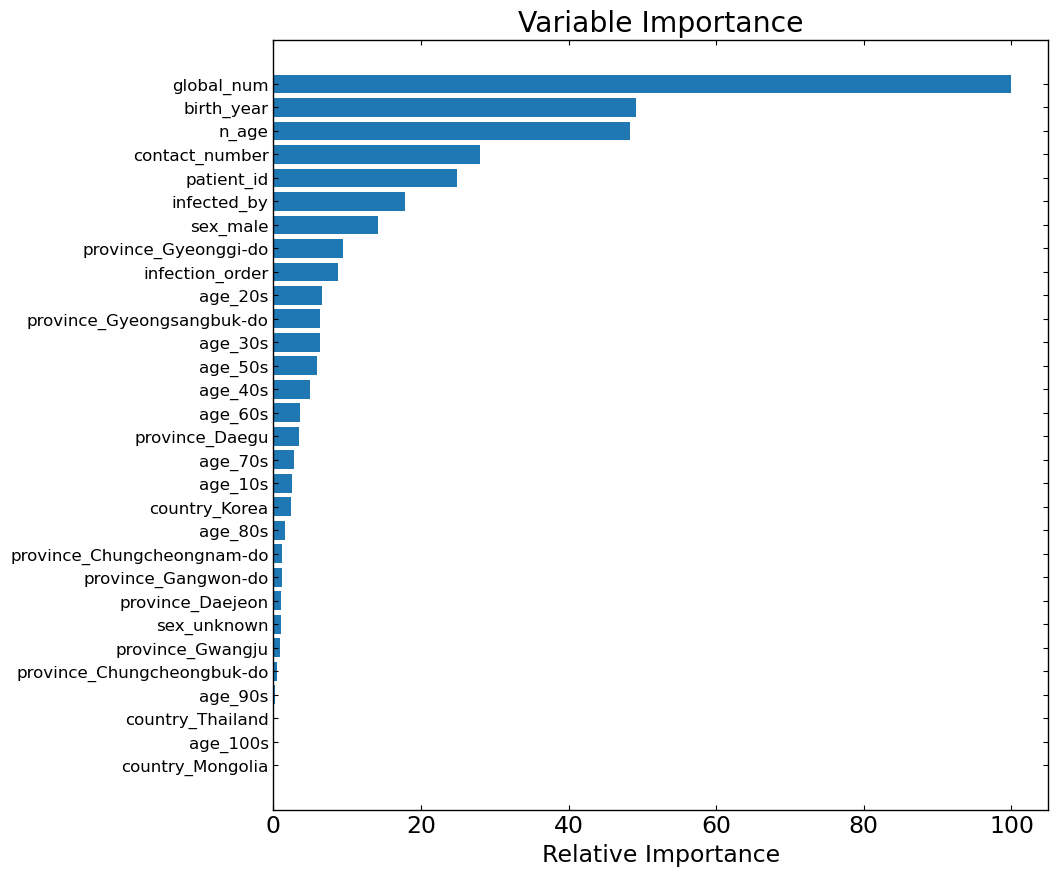

In [50]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size

fig, ax = plt.subplots(figsize=(10,10))

ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos, X.columns[sorted_idx])
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')
ax.tick_params(axis='y', labelsize=12);
#plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.